# Imports and setup:

In [1]:
# import required packages
import os 
import csv
from sympy import symbols, init_printing
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
import sympy
import itertools
import scipy
import datetime
import matplotlib.dates as mdates
from pygom import DeterministicOde, Transition, SimulateOde, TransitionType, SquareLoss
from scipy.optimize import minimize

import pickle as pk
import jsonpickle as jpk

from cycler import cycler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pwlf

import pprint
ppr = pprint.PrettyPrinter()


/Users/n/.pyenv/versions/3.7.2/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
savefigs = False # whether to save specific figures for paper to .../figures directory

In [3]:
# Jupyter Specifics
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

# Model Definitions

In [4]:
#from models import *
from model_fits import *

loading data.py...
getting JHU data...
number of countries listed 274
done with JHU data.  Got  274 countries.
getting owid data...
data for population changes only slowly if at all in OWID database
done with owid data. Got 212 countries
WHO acute file found dictionary acute_who
ICU file found dictionary icus_2012
done with data.py.
making the models...
SEI3R
SC3EI3R
SC3UEI3R
done with the models.


In [5]:
print(acute_dict) # WHO 2014 acute beds per 100000  edited by JSMcC to fill in missing data for 5 countries from previous years

{'Armenia': 341.07, 'Austria': 579.96, 'Azerbaijan': 354.18, 'Belgium': 567.27, 'Bulgaria': 595.04, 'Belarus': 866.42, 'Cyprus': 341.32, 'Czechia': 425.03, 'Germany': 620.83, 'Denmark': 261.67, 'Spain': 238.54, 'Estonia': 366.51, 'Finland': 307.55, 'France': 428.04, 'United Kingdom': 227.79, 'Georgia': 210.02, 'Greece': 346.25, 'Hungary': 428.87, 'Croatia': 398.84, 'Iceland': 267.32, 'Ireland': 240.44, 'Israel': 240.6, 'Italy': 274.57, 'Kazakhstan': 418.76, 'Kyrgyzstan': 353.86, 'Latvia': 339.21, 'Lithuania': 634.39, 'Luxembourg': 418.99, 'Monaco': 1119.0, 'Macedonia': 301.66, 'Moldova': 454.62, 'Malta': 323.9, 'Montenegro': 391.18, 'Netherlands': 332.38, 'Norway': 342.52, 'Poland': 487.68, 'Portugal': 325.13, 'Romania': 402.61, 'Russia': 640.69, 'Serbia': 456.25, 'Slovakia': 491.29, 'Slovenia': 423.03, 'Sweden': 234.5, 'Switzerland': 375.08, 'Tajikistan': 425.14, 'Turkey': 258.8, 'Turkmenistan': 306.4, 'Ukraine': 613.31, 'Uzbekistan': 333.87, 'ARM': 341.07, 'AUT': 579.96, 'AZE': 354.1

In [6]:
print(icu_dict) # Intensive Care Med (2012) 38:1647–1653 DOI 10.1007/s00134-012-2627-8   IMCUs and ICUs per 100000  in 2012

{'Andorra': 7.1, 'Austria': 21.8, 'Belgium': 15.9, 'Bulgaria': 12.2, 'Croatia': 14.7, 'Cyprus': 11.4, 'Czechia': 11.6, 'Denmark': 6.7, 'Estonia': 14.6, 'Finland': 6.1, 'France': 11.6, 'Germany': 29.2, 'Greece': 6.0, 'Hungary': 13.8, 'Iceland': 9.1, 'Ireland': 6.5, 'Italy': 12.5, 'Latvia': 9.7, 'Lithuania': 15.5, 'Luxembourg': 24.8, 'Netherlands': 6.4, 'Norway': 8.0, 'Poland': 6.9, 'Portugal': 4.2, 'Romania': 21.4, 'Slovakia': 9.2, 'Slovenia': 6.4, 'Spain': 9.7, 'Sweden': 5.8, 'Switzerland': 11.0, 'United Kingdom': 6.6}


In [8]:
(len(icu_dict),len(acute_dict))


(31, 98)

# Test ModelFit

In [10]:
testfit = ModelFit('SC3EI3R',country='Germany',run_id="_tst")

============= SC3EI3R_Germany_tst
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_tst.pk :


In [8]:
testfit.dumpparams()

dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_tst.pk


In [9]:
testfit.stopdate

'09/11/20'

In [10]:
testfit.prparams()

params:
{'N': 1,
 'alpha': 0.2,
 'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'c_0': 0.1,
 'c_1': 0.015,
 'c_2': 10000.0,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666666,
 'gamma_3': 0.10000000000000003,
 'mu': 0.09999999999999998,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333334}
sbparams:
{'CFR': 0.05,
 'DurHosp': 4,
 'DurMildInf': 10,
 'Exposure': 0.4,
 'FracCritical': 0.10000000000000003,
 'FracMild': 0.7,
 'FracSevere': 0.2,
 'I0': 3e-07,
 'ICUFrac': 0.001,
 'IncubPeriod': 5,
 'TimeICUDeath': 5}
pfbarams:
{'FracConfirmedDet': 1.0, 'FracDeathsDet': 1.0, 'FracRecoveredDet': 1.0}
cbparams:
{'CautionFactor': 0.1,
 'CautionICUFrac': 0.1,
 'CautionRetention': 66.66666666666667,
 'EconomicCostOfCaution': 0.5,
 'EconomicRetention': 66.66666666666667,
 'EconomicStriction': 66.66666666666667,
 'EconomyRelaxation': 66.66666666666667}
dbparams:
{'country': 'Germany', 'data_src': 'owid', 'run_name': 'SC3EI3R'}


In [9]:
# this cell for debugging methods, as needed.
# copy method here, uncomment appropriate setattr() call below, debug, copy method back to model_fits.py


#MyClass = ModelFit('SC3EI3R',run_id='tst').__class__
#setattr(MyClass,'__init__',__init__)
#setattr(MyClass,'dumpparams',dumpparams)
#setattr(MyClass,'__init__',__init__)
#setattr(MyClass,'loadparams',loadparams)
#setattr(MyClass,'prparams',prparams)



============= tst
no file available with this run_id /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/tst.pk
Problem loading paramfile for tst ... using default set of parameters for model type SC3EI3R


In [13]:
testfit.loadparams()

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_tst.pk :
-------  params from file:
{'cbparams': {'CautionFactor': 0.1,
              'CautionICUFrac': 0.1,
              'CautionRetention': 66.66666666666667,
              'EconomicCostOfCaution': 0.5,
              'EconomicRetention': 66.66666666666667},
 'dbparams': {'country': 'Germany', 'data_src': 'owid', 'run_name': 'SC3EI3R'},
 'fbparams': {'FracConfirmedDet': 1.0,
              'FracDeathsDet': 1.0,
              'FracRecoveredDet': 1.0},
 'initial_values': (array([9.999997e-01, 0.000000e+00, 3.000000e-07, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00]),
                    0),
 'params': {'N': 1,
            'alpha': 0.2,
            'beta_1': 0.4,
            'beta_2': 0.0,
            'beta_3': 0.0,
            'c_0': 0.1,
            'c_1': 0.015,
            'c_2': 10000.0,
            'gamma_1': 0.0699

True

In [15]:
testfit2 = ModelFit('SC3UEI3R',model=None,country='Italy',run_id='testfit2',datatypes='all',data_src='owid',startdate='2/15/20',stopdate='8/31/20',simdays=300)

no file available with this run_id /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/testfit2.pk
using default set of parameters for model type SC3UEI3R
stopdate 8/31/20


In [9]:
print(testfit2.startdate,'to',testfit2.stopdate)
print(len(testfit2.tsim),len(testfit2.tdata))

02/15/20 to 08/31/20
300 199


## Debugging of plotdata

Following cells are set up to debug methods of the ModelFit class without restarting kernel and reloading model_fits.py.

Edit functions here, then when debugged, copy them into the class definition of model_fits.py.

In [46]:
# simple plot of data : finessing dates issue
def plotdata(self,dtypes=['confirmed','deaths']):
        if type(dtypes)==str:
            dtypes = [dtypes]
        xx = np.array(range(len(self.tdata)-1))
        print(len(xx))
        print([(x,len(self.data[x])) for x in dtypes])

        for dt in dtypes:
            try:
                yy = self.data[dt]
            except:
                print("data type '"+dt+"' not found.")
            try:
                plt.plot(xx,yy)
            except:
                print("couldn't plot xx,yy",xx,yy)
        plt.show()

MyClass = ModelFit('tst','SC3EI3R').__class__
#setattr(MyClass,'__init__',__init__)
setattr(MyClass,'plotdata',plotdata)


no file available with this run_id /Users/john/projects/Covid-19/covid-recovery/Notebooks/covid-19-caution/params/tst.pk
using default set of parameters for model type SC3EI3R


## Plotting simulation and data with solveplot method

fit data  (256, 2)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_tst.pk


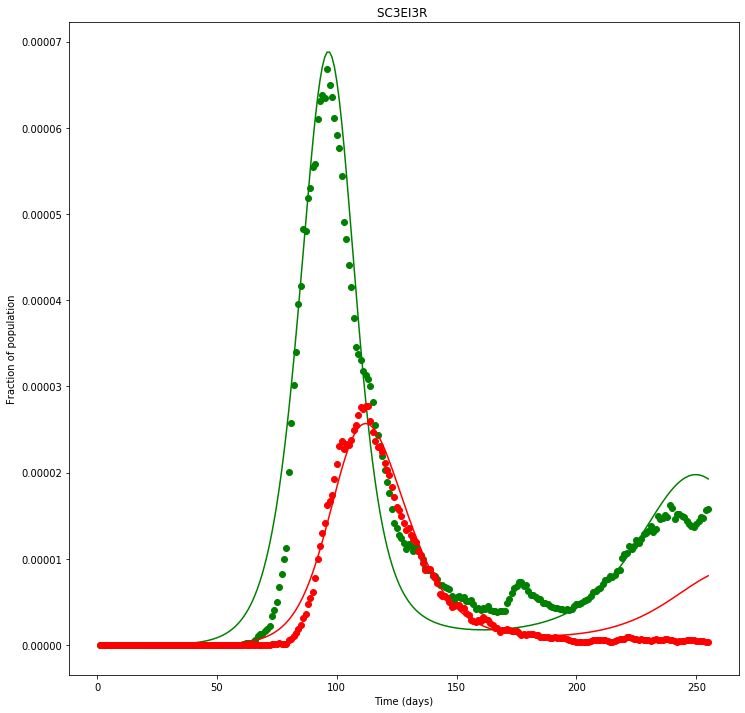

In [17]:
testfit.solveplot(species=['confirmed','deaths'],mag={'deaths':10},summing='daily',averaging='weekly',axes=None,
                   scale='linear',plottitle= '',label='',newplot = True, gbrcolors=False, figsize = (12,12), outfile = 'tst.pdf')

In [16]:
testfit.prparams()

params:
{'N': 1,
 'alpha': 0.2,
 'beta_1': 0.36,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'c_0': 0.1,
 'c_1': 0.012,
 'c_2': 4881.0,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666666,
 'gamma_3': 0.10000000000000003,
 'mu': 0.09999999999999998,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333334}
sbparams:
{'CFR': 0.05,
 'DurHosp': 4,
 'DurMildInf': 10,
 'Exposure': 0.4,
 'FracCritical': 0.10000000000000003,
 'FracMild': 0.7,
 'FracSevere': 0.2,
 'I0': 2.3442288153199228e-08,
 'ICUFrac': 0.001,
 'IncubPeriod': 5,
 'TimeICUDeath': 5}
pfbarams:
{'FracConfirmedDet': 1.0, 'FracDeathsDet': 1.0, 'FracRecoveredDet': 1.0}
cbparams:
{'CautionFactor': 0.1,
 'CautionICUFrac': 0.1,
 'CautionRetention': 66.66666666666667,
 'EconomicCostOfCaution': 0.5,
 'EconomicRetention': 66.66666666666667,
 'EconomicStriction': 66.66666666666667,
 'EconomyRelaxation': 66.66666666666667}
dbparams:
{'country': 'Germany', 'data_src': 'owid', 'run_name': 'SC3EI3R'}
initial_values:
(array([9.999997e-01, 

In [41]:
testfit.prparams()

params:
{'N': 1,
 'alpha': 0.2,
 'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'c_0': 0.1,
 'c_1': 0.015,
 'c_2': 10000.0,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'mu': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333}
sbparams:
{'CFR': 0.05,
 'DurHosp': 4,
 'DurMildInf': 10,
 'Exposure': 0.4,
 'FracCritical': 0.1,
 'FracMild': 0.7,
 'FracSevere': 0.2,
 'I0': 3e-07,
 'ICUFrac': 0.001,
 'IncubPeriod': 5,
 'TimeICUDeath': 5}
pfbarams:
{'FracConfirmedDet': 1.0, 'FracDeathsDet': 1.0, 'FracRecoveredDet': 1.0}
cbparams:
{'CautionFactor': 0.1,
 'CautionICUFrac': 0.1,
 'CautionRetention': 66.66666666666667,
 'EconomicCostOfCaution': 0.5,
 'EconomicRetention': 66.66666666666667}
dbparams:
{'country': 'Germany', 'data_src': 'owid', 'run_name': 'SC3EI3R'}


# Fitting simulation and data with sliders

## Germany

In [55]:
testfit = ModelFit('SC3EI3R',country='Germany',run_id='SC3EI3R_Germany_tst',simdays=200)

no file available with this run_id /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_tst.pk
using default set of parameters for model type SC3EI3R


In [19]:
def slidefitplot(modelfit,beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    for pp in params:             # careful to keep intact rest of params that don't have sliders
        modelfit.params[pp] = params[pp]
    modelfit.model.parameters = modelfit.params  
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]
    modelfit.model.initial_values = (x0,0)
    modelfit.sbparams['I0'] = I0        
    modelfit.solveplot(species=['confirmed','deaths'],mag={'deaths':10},summing='daily',averaging='weekly',axes=None,
                   scale='linear',plottitle= '',label='',newplot = True, gbrcolors=False, 
                       figsize = (15,10),outfile = testfit.run_id+'.pdf')

In [20]:

params=testfit.params
logI_0 = np.log10(testfit.sbparams['I0'])
w =interactive(slidefitplot,modelfit=fixed(testfit),
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=logI_0,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

interactive(children=(FloatSlider(value=0.36, continuous_update=False, description='beta_1', layout=Layout(wid…

In [18]:
testfit.prparams(testfit.run_id+'.params')

In [15]:
testfit.prparams()

params:
{'N': 1,
 'alpha': 0.2,
 'beta_1': 0.36,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'c_0': 0.1,
 'c_1': 0.012,
 'c_2': 4881.0,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666666,
 'gamma_3': 0.10000000000000003,
 'mu': 0.09999999999999998,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333334}
sbparams:
{'CFR': 0.05,
 'DurHosp': 4,
 'DurMildInf': 10,
 'Exposure': 0.4,
 'FracCritical': 0.10000000000000003,
 'FracMild': 0.7,
 'FracSevere': 0.2,
 'I0': 2.3442288153199228e-08,
 'ICUFrac': 0.001,
 'IncubPeriod': 5,
 'TimeICUDeath': 5}
pfbarams:
{'FracConfirmedDet': 1.0, 'FracDeathsDet': 1.0, 'FracRecoveredDet': 1.0}
cbparams:
{'CautionFactor': 0.1,
 'CautionICUFrac': 0.1,
 'CautionRetention': 66.66666666666667,
 'EconomicCostOfCaution': 0.5,
 'EconomicRetention': 66.66666666666667,
 'EconomicStriction': 66.66666666666667,
 'EconomyRelaxation': 66.66666666666667}
dbparams:
{'country': 'Germany', 'data_src': 'owid', 'run_name': 'SC3EI3R'}
initial_values:
(array([9.999997e-01, 

149
[('confirmed', 149), ('deaths', 149)]


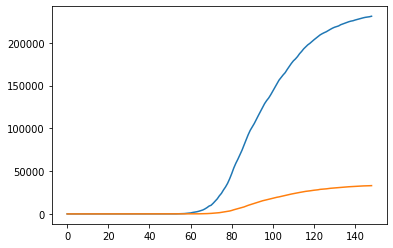

In [48]:
testfit.plotdata()

# I left this cell in so you can see how one can use the mdates together with my data structures to add real dates to the plots
# Have to replace xx with the dates in the solveplot method in that case

def truncx(xx,daystart,daystop):
    """truncate array xx to run from daystart to daystop
       do this before trying to extend the arrays if required"""
    daymin = max(daystart,0)
    daymax = min(daystop,(xx[-1]-xx[0]).days)
    return xx[daymin:daymax+1]

def truncy(xx,yy,daystart,daystop):
    """truncate arrays xx and yy to run from daystart to daystop
       do this before trying to extend the arrays if required"""
    daymin = max(daystart,0)
    daymax = min(daystop,(xx[-1]-xx[0]).days)
    return yy[daymin:daymax+1]

def plotCountry_(country_s, datatype='confirmed', dataaccum='cumulative', fittype=None, ax=None, ax2=False,
                symbol='o--', step=None, firstdate=None, lastdate=None, intdates=False, linecolor=None, maxyval=None, minconfirmed=0,nsegments=3,database='jhu'):
    """ plots selected data for a list of countries or single country
        datatypes allowed are 'confirmed','deaths','recovered'
        dataaccum specifies either 'cumulative' or 'daily' or averaged over 7 days 'cum_av_weekly' or 'daily_av_weekly'
        fittypes allowed are currently None, 'piecewise-linear'
        ax graphical axes to use for plot: default None -> new axes
        ax2 true if second axes as twin axes for overlay plotting
        symbol to use for plotting
        step whether to use step plotting instead of points: default None -> points
        firstdate to plot (maybe before first date in data - pad with 0)
        lastdate to plot (maybe after last date in data - pad with 0)
        intdates : whether to plot dates as integers for compatibility (default as dates)
        linecolor is default color to use for a single trace, instead of listed set)
    """
    global covid_ts, covid_ts_owid
    import math
    import warnings
    # extract list of countries in [(country,region),...] format from first parameter
    countries = []
    if isinstance(country_s,list):
        for country in country_s:
            if isinstance(country,str) and database == 'jhu':
                country = (country,'')
            countries.append(country)
    elif isinstance(country_s,str):
        if database == 'jhu':
            countries = [( country_s,'')]
        else:
             countries = [country_s]
    else:                               # single ('country','reg') entry
        countries = [country_s]
        
    # get data with datatype and extend dates to padd desired interval specified by firstdate,lastdate
    if database == 'jhu':
        popkeyed = covid_ts[datatype]
        dates = popkeyed['dates']
        fmt = '%m/%d/%y'
    elif database == 'owid':
        popkeyed = covid_owid_ts[datatype]
        dates = popkeyed['dates']
        fmt = '%m/%d/%y'
        # fmt = '%Y-%m-%d' the owid date format was converted to the jhu date format in get_data_owid
    xxd = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)
    daystart = (firstdate_d-xxd[0]).days
    daystop = (lastdate_d-xxd[0]).days
    xx = [0.]*(daystop-daystart+1)
    xx = truncx(xxd,daystart,daystop)                                     # truncates list to chosen date interval    !!!!!!!!!!!!!!!!!!!!!!!!!       
    # print('1 len xx',len(xx))
    
    if daystart <0:
        xx0 = [xx[0]+datetime.timedelta(days=i) for i in range(daystart,0)]
        yy0 = [0.]*(-daystart)
    else:
        xx0 = []
        yy0 = []

    if daystop > (xxd[-1]-xxd[0]).days:
        xx1 = [xxd[-1]+datetime.timedelta(days=i) for i in range(daystop-(xxd[-1]-xxd[0]).days)]
        yy1 = [' ']*(daystop-(xxd[-1]-xxd[0]).days)
    else:
        xx1 = []
        yy1 = []       
    xx = xx0 + xx + xx1
    # print('2 len xx',len(xx))
    #print('len xx1 yy1',len(xx1),len(yy1))
    
    # print('len xx',len(xx))
    if fittype == 'piecewise-linear':
        xxi = [Float((x-xx[0]).days) for x in xx ]
        # print(xxi)
    # print('len xxi',len(xxi))    
    # locator = mdates.MonthLocator()
    locator = mdates.AutoDateLocator(minticks=5, maxticks=13)
    formatter= mdates.ConciseDateFormatter(locator)
    
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(9,6)) 
        ax2 = ax
    elif ax2:
        ax2 = ax.twinx()
    else:
        ax2 = ax
        
    colors =  ['k', 'b', 'c', 'm', 'y', 'g', 'olive', 'chocolate']
        
    i = 0
    j = 0
    for country in countries:
        try:
            yyd = popkeyed[country]
            if np.max(yyd) >= minconfirmed:
                j = j+1
            else:
                i = i + 1
                continue
        except:
            print('country not found',country)
            i = i + 1
            continue
        yy = truncy(xxd,yyd,daystart,daystop)
        # print(country,'1 len yy yyd',len(yy),len(yyd))
        yyf = [Float(y) for y in yy]
        yy = yy0 + yyf + yy1
        # print(country,'2 len yy',len(yy))
        # ymax=np.max(np.array(yy))
        yyf = [Float(y) for y in yy]
        if dataaccum == 'daily':
            yy = [0.]*len(yy)
            yy[0] = yyf[0]
            for k in range(1,len(yy)):
                yy[k] = yyf[k]-yyf[k-1]   
        elif dataaccum == 'cum_av_weekly':
            yy = [0.]*len(yy)
            moving_av = 0.
            for k in range(len(yy)):
                if k-7 >= 0:
                    moving_av = moving_av - yyf[k-7]
                moving_av = moving_av + yyf[k]
                yy[k] = moving_av/min(7.0,float(k+1))
        elif dataaccum == 'daily_av_weekly':
            yy = [0.]*len(yyf)
            yy[0] = yyf[0]
            for k in range(1,len(yy)):
                yy[k] = yyf[k]-yyf[k-1]
            yyf = [y for y in yy]
            yy = [0.]*len(yy)
            moving_av = 0.
            for k in range(len(yy)):
                if k-7 >= 0:
                    moving_av = moving_av - yyf[k-7]
                moving_av = moving_av + yyf[k]
                yy[k] = moving_av/min(7.0,float(k+1))
        if intdates:
            xx = range(len(xx))
        
        if step:
            ax2.step(xx,yy,label = country[0])
        else:
            # print(ax,ax2)
            # ax2.set_ylim(ymax,0)
            if linecolor:
                color = linecolor
            else:
                color = colors[i]

            ax2.plot(xx, yy, symbol, markersize=3, color = color, alpha=0.8, label = country[0])

        if maxyval: ax.set_ylim(0,maxyval)
        if maxyval: ax2.set_ylim(0,maxyval)
            
        plt.title(country[0]+'-'+country[1])  # +' '+datatype)
        if fittype == 'piecewise-linear':    
            warnings.filterwarnings("ignore", message="Warning: zero length interval encountered in pwlf.py calc_slopes")
            # initialize piecewise linear fit with your x and y data
            # yyf = [Float(y) for y in yy]
            yyf = [Float(y) if not math.isnan(y) else 0.0 for y in yy]
            # print(yyf)
            my_pwlf = pwlf.PiecewiseLinFit(xxi, yyf)
            # fit the data for three line segments
            res = my_pwlf.fit(nsegments)
            
            ppp = my_pwlf.p_values(method='non-linear', step_size=1e-4)
            se = my_pwlf.se  # standard errors
            parameters = np.concatenate((my_pwlf.beta,
                             my_pwlf.fit_breaks[1:-1]))
            header = ['Parameter type', 'Parameter value ', 'Standard error  ', 't               ', 'P > np.abs(t) (p-value)']
            print(*header, sep=' | ')
            fltfmt = "{:12.3f}".format
            values = np.zeros((parameters.size, 5), dtype=np.object_)
            values[:, 1] = [fltfmt(np.around(term, decimals=3)) for term in parameters]
            values[:, 2] = [fltfmt(np.around(term, decimals=3)) for term in se]
            values[:, 3] = [fltfmt(np.around(term, decimals=3)) for term in parameters/se]
            values[:, 4] = [fltfmt(np.around(term, decimals=3)) for term in ppp]
            for iii, row in enumerate(values):
                if iii < my_pwlf.beta.size:
                    row[0] = 'Slope     '
                    
                    print(*row, sep='     | ')
                else:
                    row[0] = 'Breakpoint'
                    print(*row, sep='     | ')
            print("")      
            # predict for the determined points
            xHat = np.linspace(min(xxi), max(xxi), num=len(xx))
            # print(len(xHat),len(xxi))
            yHat = my_pwlf.predict(xHat)
            ax2.plot(xx, yHat, color = colors[i], alpha=0.5, label = country[0]+' fit')
            
        i = i+1

    if j==0:
        ax.axis("off")
    else:
        if j > 1:
            plt.legend(loc="upper left")
            plt.title('countries '+datatype+dataaccum)
        if not intdates:
            ax2.xaxis.set_major_formatter(formatter)
            ax2.xaxis.set_major_locator(locator)
            for tick in ax2.get_xticklabels():
                tick.set_rotation(40)



## Spain

In [29]:
testfit = ModelFit('SC3EI3R',country='Spain',run_id='_tst',stopdate='09/10/20')

============= SC3EI3R_Spain_tst
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Spain_tst.pk :
stopdate 09/10/20


In [30]:
print([x for x in dir(testfit) if 'date' in x])
testfit.stopdate

['dates', 'startdate', 'stopdate']


'09/10/20'

In [44]:
[pp for pp in testfit.params]

['beta_1',
 'beta_2',
 'beta_3',
 'alpha',
 'gamma_1',
 'gamma_2',
 'gamma_3',
 'p_1',
 'p_2',
 'mu',
 'c_0',
 'c_1',
 'c_2',
 'N']

In [59]:
def slidefitplot(modelfit,beta_1,alpha,gamma_1,gamma_2,gamma_3,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'alpha':alpha,'gamma_1':gamma_1,'gamma_2':gamma_2,'gamma_3':gamma_3,
            'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    for pp in params:             # careful to keep intact rest of params that don't have sliders
        modelfit.params[pp] = params[pp]
    modelfit.model.parameters = modelfit.params  
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]
    modelfit.model.initial_values = (x0,0)
    modelfit.sbparams['I0'] = I0        
    modelfit.solveplot(species=['confirmed','deaths'],mag={'deaths':10},summing='daily',averaging='weekly',axes=None,
                   scale='linear',plottitle= '',label='',newplot = True, gbrcolors=False, 
                       figsize = (15,10),outfile = testfit.run_id+'.pdf')

In [60]:

params=testfit.params
logI_0 = np.log10(testfit.sbparams['I0'])
w =interactive(slidefitplot,modelfit=fixed(testfit),
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_1=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_1'],description='gamma_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_2=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_2'],description='gamma_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_3=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_3'],description='gamma_3',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),                    
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=logI_0,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

interactive(children=(FloatSlider(value=0.4, continuous_update=False, description='beta_1', layout=Layout(widt…

In [43]:
testfit.prparams(testfit.run_id+'.params')

In [33]:
testfit.prparams()

params:
{'N': 1,
 'alpha': 0.2,
 'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'c_0': 0.12,
 'c_1': 0.04,
 'c_2': 2575.0,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666666,
 'gamma_3': 0.10000000000000003,
 'mu': 0.042,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333334}
sbparams:
{'CFR': 0.05,
 'DurHosp': 4,
 'DurMildInf': 10,
 'Exposure': 0.4,
 'FracCritical': 0.10000000000000003,
 'FracMild': 0.7,
 'FracSevere': 0.2,
 'I0': 1.5848931924611143e-08,
 'ICUFrac': 0.001,
 'IncubPeriod': 5,
 'TimeICUDeath': 5}
pfbarams:
{'FracConfirmedDet': 1.0, 'FracDeathsDet': 1.0, 'FracRecoveredDet': 1.0}
cbparams:
{'CautionFactor': 0.1,
 'CautionICUFrac': 0.1,
 'CautionRetention': 66.66666666666667,
 'EconomicCostOfCaution': 0.5,
 'EconomicRetention': 66.66666666666667,
 'EconomicStriction': 66.66666666666667,
 'EconomyRelaxation': 66.66666666666667}
dbparams:
{'country': 'Germany', 'data_src': 'owid', 'run_name': 'SC3EI3R'}
initial_values:
(array([9.999997e-01, 0.000000e+00, 3

## Italy

In [61]:
testfit = ModelFit('SC3EI3R',country='Italy',run_id='_tst',stopdate='09/10/20')

============= SC3EI3R_Italy_tst
no file available with this run_id /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Italy_tst.pk
Problem loading paramfile for _tst ... using default set of parameters for model type SC3EI3R
stopdate 09/10/20


In [62]:
print([x for x in dir(testfit) if 'date' in x])
testfit.stopdate

['dates', 'startdate', 'stopdate']


'09/10/20'

In [63]:
def slidefitplot(modelfit,beta_1,alpha,gamma_1,gamma_2,gamma_3,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'alpha':alpha,'gamma_1':gamma_1,'gamma_2':gamma_2,'gamma_3':gamma_3,
            'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    for pp in params:             # careful to keep intact rest of params that don't have sliders
        modelfit.params[pp] = params[pp]
    modelfit.model.parameters = modelfit.params  
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]
    modelfit.model.initial_values = (x0,0)
    modelfit.sbparams['I0'] = I0        
    modelfit.solveplot(species=['confirmed','deaths'],mag={'deaths':10},summing='daily',averaging='weekly',axes=None,
                   scale='linear',plottitle= '',label='',newplot = True, gbrcolors=False, 
                       figsize = (15,10),outfile = testfit.run_id+'.pdf')

In [64]:

params=testfit.params
logI_0 = np.log10(testfit.sbparams['I0'])
w =interactive(slidefitplot,modelfit=fixed(testfit),
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_1=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_1'],description='gamma_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_2=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_2'],description='gamma_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_3=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_3'],description='gamma_3',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),                    
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=logI_0,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

interactive(children=(FloatSlider(value=0.4, continuous_update=False, description='beta_1', layout=Layout(widt…

In [66]:
from shutil import copyfile

In [69]:
testfit.prparams(testfit.run_id+'.params')
paramfile = './params/'+testfit.run_id+'.pk'
copyfile(paramfile,testfit.run_id+'.pk')

'SC3EI3R_Italy_tst.pk'

## Brazil

In [70]:
testfit = ModelFit('SC3EI3R',country='Brazil',run_id='_tst',stopdate='09/10/20')

============= SC3EI3R_Brazil_tst
no file available with this run_id /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Brazil_tst.pk
Problem loading paramfile for _tst ... using default set of parameters for model type SC3EI3R
stopdate 09/10/20


In [71]:
print([x for x in dir(testfit) if 'date' in x])
testfit.stopdate

['dates', 'startdate', 'stopdate']


'09/10/20'

In [72]:
def slidefitplot(modelfit,beta_1,alpha,gamma_1,gamma_2,gamma_3,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'alpha':alpha,'gamma_1':gamma_1,'gamma_2':gamma_2,'gamma_3':gamma_3,
            'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    for pp in params:             # careful to keep intact rest of params that don't have sliders
        modelfit.params[pp] = params[pp]
    modelfit.model.parameters = modelfit.params  
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]
    modelfit.model.initial_values = (x0,0)
    modelfit.sbparams['I0'] = I0        
    modelfit.solveplot(species=['confirmed','deaths'],mag={'deaths':10},summing='daily',averaging='weekly',axes=None,
                   scale='linear',plottitle= '',label='',newplot = True, gbrcolors=False, 
                       figsize = (15,10),outfile = testfit.run_id+'.pdf')

In [73]:

params=testfit.params
logI_0 = np.log10(testfit.sbparams['I0'])
w =interactive(slidefitplot,modelfit=fixed(testfit),
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_1=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_1'],description='gamma_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_2=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_2'],description='gamma_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_3=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_3'],description='gamma_3',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),                    
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=logI_0,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

interactive(children=(FloatSlider(value=0.4, continuous_update=False, description='beta_1', layout=Layout(widt…

In [66]:
from shutil import copyfile

In [69]:
testfit.prparams(testfit.run_id+'.params')
paramfile = './params/'+testfit.run_id+'.pk'
copyfile(paramfile,testfit.run_id+'.pk')

'SC3EI3R_Italy_tst.pk'

## Sweden

### SC3EI3R

In [74]:
testfit = ModelFit('SC3EI3R',country='Sweden',run_id='_tst',stopdate='09/10/20')

============= SC3EI3R_Sweden_tst
no file available with this run_id /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Sweden_tst.pk
Problem loading paramfile for _tst ... using default set of parameters for model type SC3EI3R
stopdate 09/10/20


In [75]:
print([x for x in dir(testfit) if 'date' in x])
testfit.stopdate

['dates', 'startdate', 'stopdate']


'09/10/20'

In [76]:
def slidefitplot(modelfit,beta_1,alpha,gamma_1,gamma_2,gamma_3,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'alpha':alpha,'gamma_1':gamma_1,'gamma_2':gamma_2,'gamma_3':gamma_3,
            'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    for pp in params:             # careful to keep intact rest of params that don't have sliders
        modelfit.params[pp] = params[pp]
    modelfit.model.parameters = modelfit.params  
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]
    modelfit.model.initial_values = (x0,0)
    modelfit.sbparams['I0'] = I0        
    modelfit.solveplot(species=['confirmed','deaths'],mag={'deaths':10},summing='daily',averaging='weekly',axes=None,
                   scale='linear',plottitle= '',label='',newplot = True, gbrcolors=False, 
                       figsize = (15,10),outfile = testfit.run_id+'.pdf')

In [77]:

params=testfit.params
logI_0 = np.log10(testfit.sbparams['I0'])
w =interactive(slidefitplot,modelfit=fixed(testfit),
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_1=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_1'],description='gamma_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_2=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_2'],description='gamma_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_3=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_3'],description='gamma_3',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),                    
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=logI_0,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

interactive(children=(FloatSlider(value=0.4, continuous_update=False, description='beta_1', layout=Layout(widt…

In [66]:
from shutil import copyfile

In [78]:
testfit.prparams(testfit.run_id+'.params')
paramfile = './params/'+testfit.run_id+'.pk'
copyfile(paramfile,testfit.run_id+'.pk')

'SC3EI3R_Sweden_tst.pk'

### SC3UEI3R

In [81]:
testfit = ModelFit('SC3UEI3R',country='Sweden',run_id='_tst',stopdate='09/10/20')

============= SC3UEI3R_Sweden_tst
no file available with this run_id /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Sweden_tst.pk
Problem loading paramfile for _tst ... using default set of parameters for model type SC3UEI3R
stopdate 09/10/20


In [82]:
print([x for x in dir(testfit) if 'date' in x])
testfit.stopdate

['dates', 'startdate', 'stopdate']


'09/10/20'

In [88]:
def slidefitplot(modelfit,beta_1,alpha,gamma_1,gamma_2,gamma_3,mu,c_0,c_1,c_2,logI_0,k_u,k_1,k_w,kappa):
    params={ 'beta_1':beta_1, 'alpha':alpha,'gamma_1':gamma_1,'gamma_2':gamma_2,'gamma_3':gamma_3,
            'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2,'k_u':k_u, 'k_1':k_1, 'k_w':k_w, 'kappa':kappa}
    for pp in params:             # careful to keep intact rest of params that don't have sliders
        modelfit.params[pp] = params[pp]
    modelfit.model.parameters = modelfit.params  
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.0,0.0]
    modelfit.model.initial_values = (x0,0)
    modelfit.sbparams['I0'] = I0        
    modelfit.solveplot(species=['confirmed','deaths'],mag={'deaths':10},summing='daily',averaging='weekly',axes=None,
                   scale='linear',plottitle= '',label='',newplot = True, gbrcolors=False, 
                       figsize = (15,10),outfile = testfit.run_id+'.pdf')

In [89]:

params=testfit.params
logI_0 = np.log10(testfit.sbparams['I0'])
w =interactive(slidefitplot,modelfit=fixed(testfit),
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_1=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_1'],description='gamma_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_2=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_2'],description='gamma_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         gamma_3=FloatSlider(min=0,max=0.5,step=0.002,value=params['gamma_3'],description='gamma_3',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),                    
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=logI_0,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f')
         )
display(w)

interactive(children=(FloatSlider(value=0.4, continuous_update=False, description='beta_1', layout=Layout(widt…

In [66]:
from shutil import copyfile

In [90]:
testfit.prparams(testfit.run_id+'.params')
paramfile = './params/'+testfit.run_id+'.pk'
copyfile(paramfile,testfit.run_id+'.pk')

'SC3UEI3R_Sweden_tst.pk'

# Data



## Oxford data

In [16]:
owid_file = '../../covid-policy-tracker/data/OxCGRT_latest.csv'
oxdat = []
with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        oxdat.append(row)

In [17]:
oxdat[0].keys()

odict_keys(['CountryName', 'CountryCode', 'RegionName', 'RegionCode', 'Date', 'C1_School closing', 'C1_Flag', 'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag', 'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport', 'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag', 'C7_Restrictions on internal movement', 'C7_Flag', 'C8_International travel controls', 'E1_Income support', 'E1_Flag', 'E2_Debt/contract relief', 'E3_Fiscal measures', 'E4_International support', 'H1_Public information campaigns', 'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing', 'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex', 'StringencyIndexForDisplay', 'StringencyLegacyIndex', 'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndex', 'GovernmentResponseIndexForDisplay', 'ContainmentHealthIndex', 'ContainmentHealthIndexForDisplay', 'EconomicSupportIndex', 'EconomicSupportIndexForD

In [18]:
countries = list(set([(dd['CountryName'],dd['CountryCode']) for dd in oxdat]))

In [19]:
len(countries)

185

In [20]:
[countries[i] for i in range(10)]

[('Saudi Arabia', 'SAU'),
 ('South Korea', 'KOR'),
 ('Greece', 'GRC'),
 ('Fiji', 'FJI'),
 ('Montserrat', 'MSR'),
 ('Ecuador', 'ECU'),
 ('Rwanda', 'RWA'),
 ('Romania', 'ROU'),
 ('Turks and Caicos Islands', 'TCA'),
 ('Slovak Republic', 'SVK')]

In [21]:
dates = np.sort(list([dd['Date'] for dd in oxdat]))
dates_uniq = np.unique(dates)
dates_uniq

array(['20200101', '20200102', '20200103', '20200104', '20200105',
       '20200106', '20200107', '20200108', '20200109', '20200110',
       '20200111', '20200112', '20200113', '20200114', '20200115',
       '20200116', '20200117', '20200118', '20200119', '20200120',
       '20200121', '20200122', '20200123', '20200124', '20200125',
       '20200126', '20200127', '20200128', '20200129', '20200130',
       '20200131', '20200201', '20200202', '20200203', '20200204',
       '20200205', '20200206', '20200207', '20200208', '20200209',
       '20200210', '20200211', '20200212', '20200213', '20200214',
       '20200215', '20200216', '20200217', '20200218', '20200219',
       '20200220', '20200221', '20200222', '20200223', '20200224',
       '20200225', '20200226', '20200227', '20200228', '20200229',
       '20200301', '20200302', '20200303', '20200304', '20200305',
       '20200306', '20200307', '20200308', '20200309', '20200310',
       '20200311', '20200312', '20200313', '20200314', '202003

In [22]:
foo = [(dd['Date'],dd['C1_School closing'],dd['C1_Flag']) for dd in oxdat if dd['CountryCode']=='USA']

In [23]:
xx = foo[0:10]
print(xx)
xx=foo[-10:]
print(xx)

[('20200101', '0.00', ''), ('20200102', '0.00', ''), ('20200103', '0.00', ''), ('20200104', '0.00', ''), ('20200105', '0.00', ''), ('20200106', '0.00', ''), ('20200107', '0.00', ''), ('20200108', '0.00', ''), ('20200109', '0.00', ''), ('20200110', '0.00', '')]
[('20200822', '', ''), ('20200823', '', ''), ('20200824', '', ''), ('20200825', '', ''), ('20200826', '', ''), ('20200827', '', ''), ('20200828', '', ''), ('20200829', '', ''), ('20200830', '', ''), ('20200831', '', '')]


In [24]:
ccodes = [cc[1] for cc in countries]
for cc in ccodes:
    foo = [(dd['CountryCode'],dd['RegionName']) for dd in oxdat if dd['CountryCode'] == cc]
    if len(set([x[1] for x in foo]))>1:
        print(cc)
        print( set([x[1] for x in foo]))


USA
{'', 'New Hampshire', 'California', 'Maryland', 'Tennessee', 'Rhode Island', 'Georgia', 'Louisiana', 'Virgin Islands', 'Arkansas', 'Washington', 'Iowa', 'Hawaii', 'Virginia', 'Colorado', 'Vermont', 'North Carolina', 'Oklahoma', 'West Virginia', 'Indiana', 'Delaware', 'Alaska', 'Idaho', 'Nebraska', 'Wyoming', 'Illinois', 'Texas', 'Missouri', 'New Jersey', 'Minnesota', 'South Dakota', 'Kentucky', 'New York', 'Ohio', 'North Dakota', 'Florida', 'Mississippi', 'Alabama', 'Montana', 'South Carolina', 'Wisconsin', 'Michigan', 'Washington DC', 'Oregon', 'Kansas', 'Connecticut', 'Maine', 'Arizona', 'New Mexico', 'Massachusetts', 'Nevada', 'Pennsylvania', 'Utah'}
GBR
{'', 'Wales', 'England', 'Northern Ireland', 'Scotland'}


In [25]:
[cc for cc in countries if cc[1]=='USA']

[('United States', 'USA')]

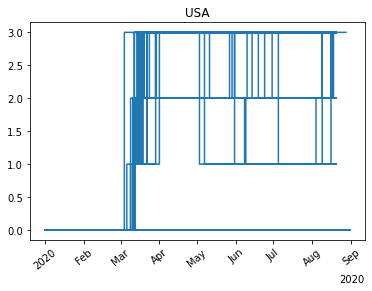

In [26]:
foo = [(dd['Date'],dd['C1_School closing'],dd['C1_Flag']) 
       for dd in oxdat if dd['CountryCode']=='USA']

fmt = '%Y%m%d'
first = 31+22-1
xx = [datetime.datetime.strptime(dd[0],fmt) for dd in foo][first:]
yy = []
for dd in foo[first:]:
    try:
        yy.append(float(dd[1]))
    except:
        yy.append(float('NaN'))


locator = mdates.MonthLocator()
formatter= mdates.ConciseDateFormatter(locator)

fig,ax = plt.subplots(1,1)
ax.step(xx,yy)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
plt.title('USA')
plt.show()

Note:  no wildcard data:

In [27]:
foo = [(dd['Date'],dd['CountryCode'],dd['M1_Wildcard']) 
       for dd in oxdat if dd['M1_Wildcard'] != '']

In [28]:
foo

[]

Notes:  
* first version of `datcodes` leaves out all flags (general vs. targeted implementation)
* 2nd version leaves out all variables measured in dollars

In [29]:
datcodes = ['C1_School closing', 'C2_Workplace closing', 
            'C3_Cancel public events', 'C4_Restrictions on gatherings', 
            'C5_Close public transport', 'C6_Stay at home requirements', 
            'C7_Restrictions on internal movement', 'C8_International travel controls', 
            'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', 
            'E4_International support', 'H1_Public information campaigns', 
            'H2_Testing policy', 'H3_Contact tracing', 
            'H4_Emergency investment in healthcare', 'H5_Investment in vaccines']

datcodes = ['C1_School closing', 'C2_Workplace closing', 
            'C3_Cancel public events', 'C4_Restrictions on gatherings', 
            'C5_Close public transport', 'C6_Stay at home requirements', 
            'C7_Restrictions on internal movement', 'C8_International travel controls', 
            'E1_Income support', 'E2_Debt/contract relief', 
            'H1_Public information campaigns', 
            'H2_Testing policy', 'H3_Contact tracing']



In [30]:
countrycodes = list(set([dd['CountryCode'] for dd in oxdat if Float(dd['ConfirmedCases'])>10000]))
len(countrycodes)

90

In [31]:
countriesox = list(set([dd['CountryName'] for dd in oxdat if Float(dd['ConfirmedCases'])>10000]))

In [32]:
len(countriesox)

90

In [33]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn


In [34]:
datcodes

['C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'E1_Income support',
 'E2_Debt/contract relief',
 'H1_Public information campaigns',
 'H2_Testing policy',
 'H3_Contact tracing']

In [35]:
def get_codedat(countrycode='USA'):
    codedat = []
    foo = [[dd['Date']]+ [Float(dd[c]) for c in datcodes]
           for dd in oxdat if dd['CountryCode']==countrycode]
    return foo
    


In [36]:
get_codedat()

[['20200101', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200102', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200103', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200104', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200105', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200106', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200107', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200108', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200109', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200110', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200111', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200112', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200113', 0.0, 0.0, 0.0, 0.0, 0.0, 0

### Stringency

In [37]:
[x for x in oxdat[0]]

['CountryName',
 'CountryCode',
 'RegionName',
 'RegionCode',
 'Date',
 'C1_School closing',
 'C1_Flag',
 'C2_Workplace closing',
 'C2_Flag',
 'C3_Cancel public events',
 'C3_Flag',
 'C4_Restrictions on gatherings',
 'C4_Flag',
 'C5_Close public transport',
 'C5_Flag',
 'C6_Stay at home requirements',
 'C6_Flag',
 'C7_Restrictions on internal movement',
 'C7_Flag',
 'C8_International travel controls',
 'E1_Income support',
 'E1_Flag',
 'E2_Debt/contract relief',
 'E3_Fiscal measures',
 'E4_International support',
 'H1_Public information campaigns',
 'H1_Flag',
 'H2_Testing policy',
 'H3_Contact tracing',
 'H4_Emergency investment in healthcare',
 'H5_Investment in vaccines',
 'M1_Wildcard',
 'ConfirmedCases',
 'ConfirmedDeaths',
 'StringencyIndex',
 'StringencyIndexForDisplay',
 'StringencyLegacyIndex',
 'StringencyLegacyIndexForDisplay',
 'GovernmentResponseIndex',
 'GovernmentResponseIndexForDisplay',
 'ContainmentHealthIndex',
 'ContainmentHealthIndexForDisplay',
 'EconomicSupportIn

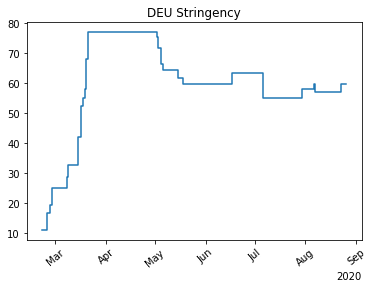

In [38]:
country='DEU'
reg = '' # to get entire country for UK, USA
foo = [(dd['Date'],dd['StringencyIndex'],dd['C1_Flag']) 
       for dd in oxdat if dd['CountryCode']==country and dd['RegionName']==reg]

fmt_ox = '%Y%m%d'
first = 31+22-1  # to get to Feb 22 where data starts
xx = [datetime.datetime.strptime(dd[0],fmt_ox) for dd in foo][first:]
yy = []
for dd in foo[first:]:
    try:
        yy.append(float(dd[1]))
    except:
        yy.append(float('NaN'))


locator = mdates.MonthLocator()
formatter= mdates.ConciseDateFormatter(locator)

fig,ax = plt.subplots(1,1)
ax.step(xx,yy)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
plt.title(country+' Stringency')
plt.show()

In [39]:
print("number of countries",len(countrycodes))

number of countries 90


In [40]:
def get_stringency(country,to_database='jhu'):
    global fmt_jhu,fmt_ox,fmt_owid,dates_jhu,dates_owid
    
    stri = [(dd['Date'],dd['StringencyIndex'],dd['C1_Flag']) 
       for dd in oxdat if dd['CountryName']==country and dd['RegionName']=='']
    fmt_ox = '%Y%m%d'
    #first = 31+22-1  # to get to Feb 22 where data starts
    dates_t = [datetime.datetime.strptime(dd[0],fmt_ox) for dd in stri]
    
    if to_database=='jhu':
        fmt = fmt_jhu
        dates = dates_jhu
    elif to_database=='owid':
        fmt = fmt_jhu   # already converted from fmt_owid
        dates = dates_owid
    print('first date',dates[0],'last date',dates[-1])
    firstdate = datetime.datetime.strptime(dates[0],fmt)
    lastdate = datetime.datetime.strptime(dates[-1],fmt)
    ndates=len(dates)
    daystart = (dates_t[0]-firstdate).days
    
    #dates = [date.strftime(fmt_jhu) for date in dates_t]
    yy = np.zeros((lastdate-firstdate).days+1)
    for i,dd in enumerate(stri):
        if daystart+i < len(dates):
            try:
                yy[daystart+i]=float(dd[1])
            except:
                yy[daystart+i]=float('NaN')
    return([dates,yy])
    

first date 1/22/20 last date 8/30/20


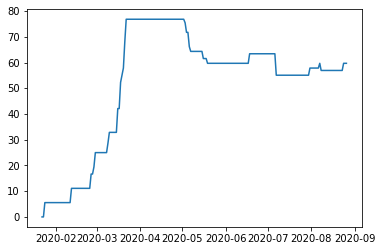

In [41]:
stri = get_stringency('Germany',to_database='jhu')
plt.plot([datetime.datetime.strptime(date,fmt_jhu) for date in stri[0]],stri[1]);

first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20


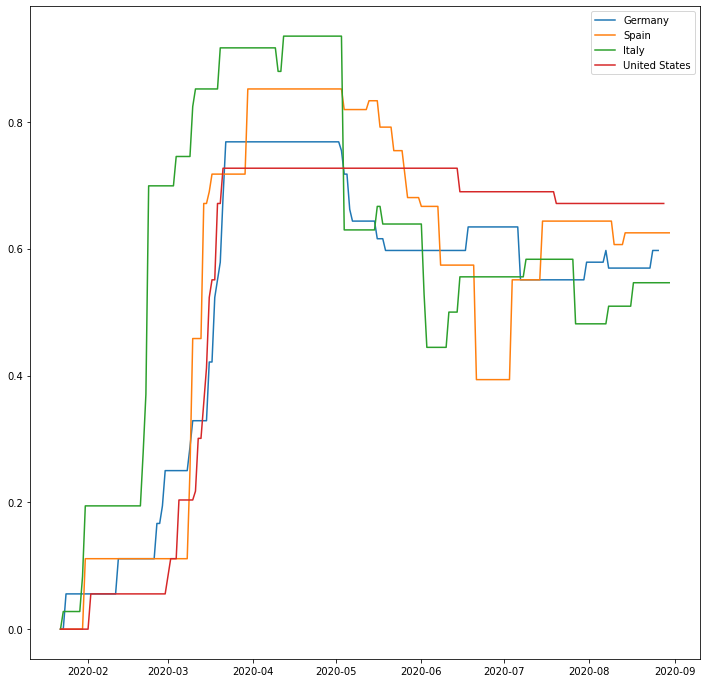

In [42]:
stri = get_stringency('Germany')
datesf = [datetime.datetime.strptime(date,fmt_jhu) for date in stri[0]]
plt.figure(figsize=(12,12))
plt.plot(datesf,np.array(stri[1])/100.,label='Germany');
stri = get_stringency('Spain')
plt.plot(datesf,np.array(stri[1])/100.,label='Spain');
stri = get_stringency('Italy')
plt.plot(datesf,np.array(stri[1])/100.,label='Italy');
stri = get_stringency('United States')
plt.plot(datesf,np.array(stri[1])/100.,label='United States');
plt.legend()

In [43]:
import matplotlib.dates as mdates


first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
f

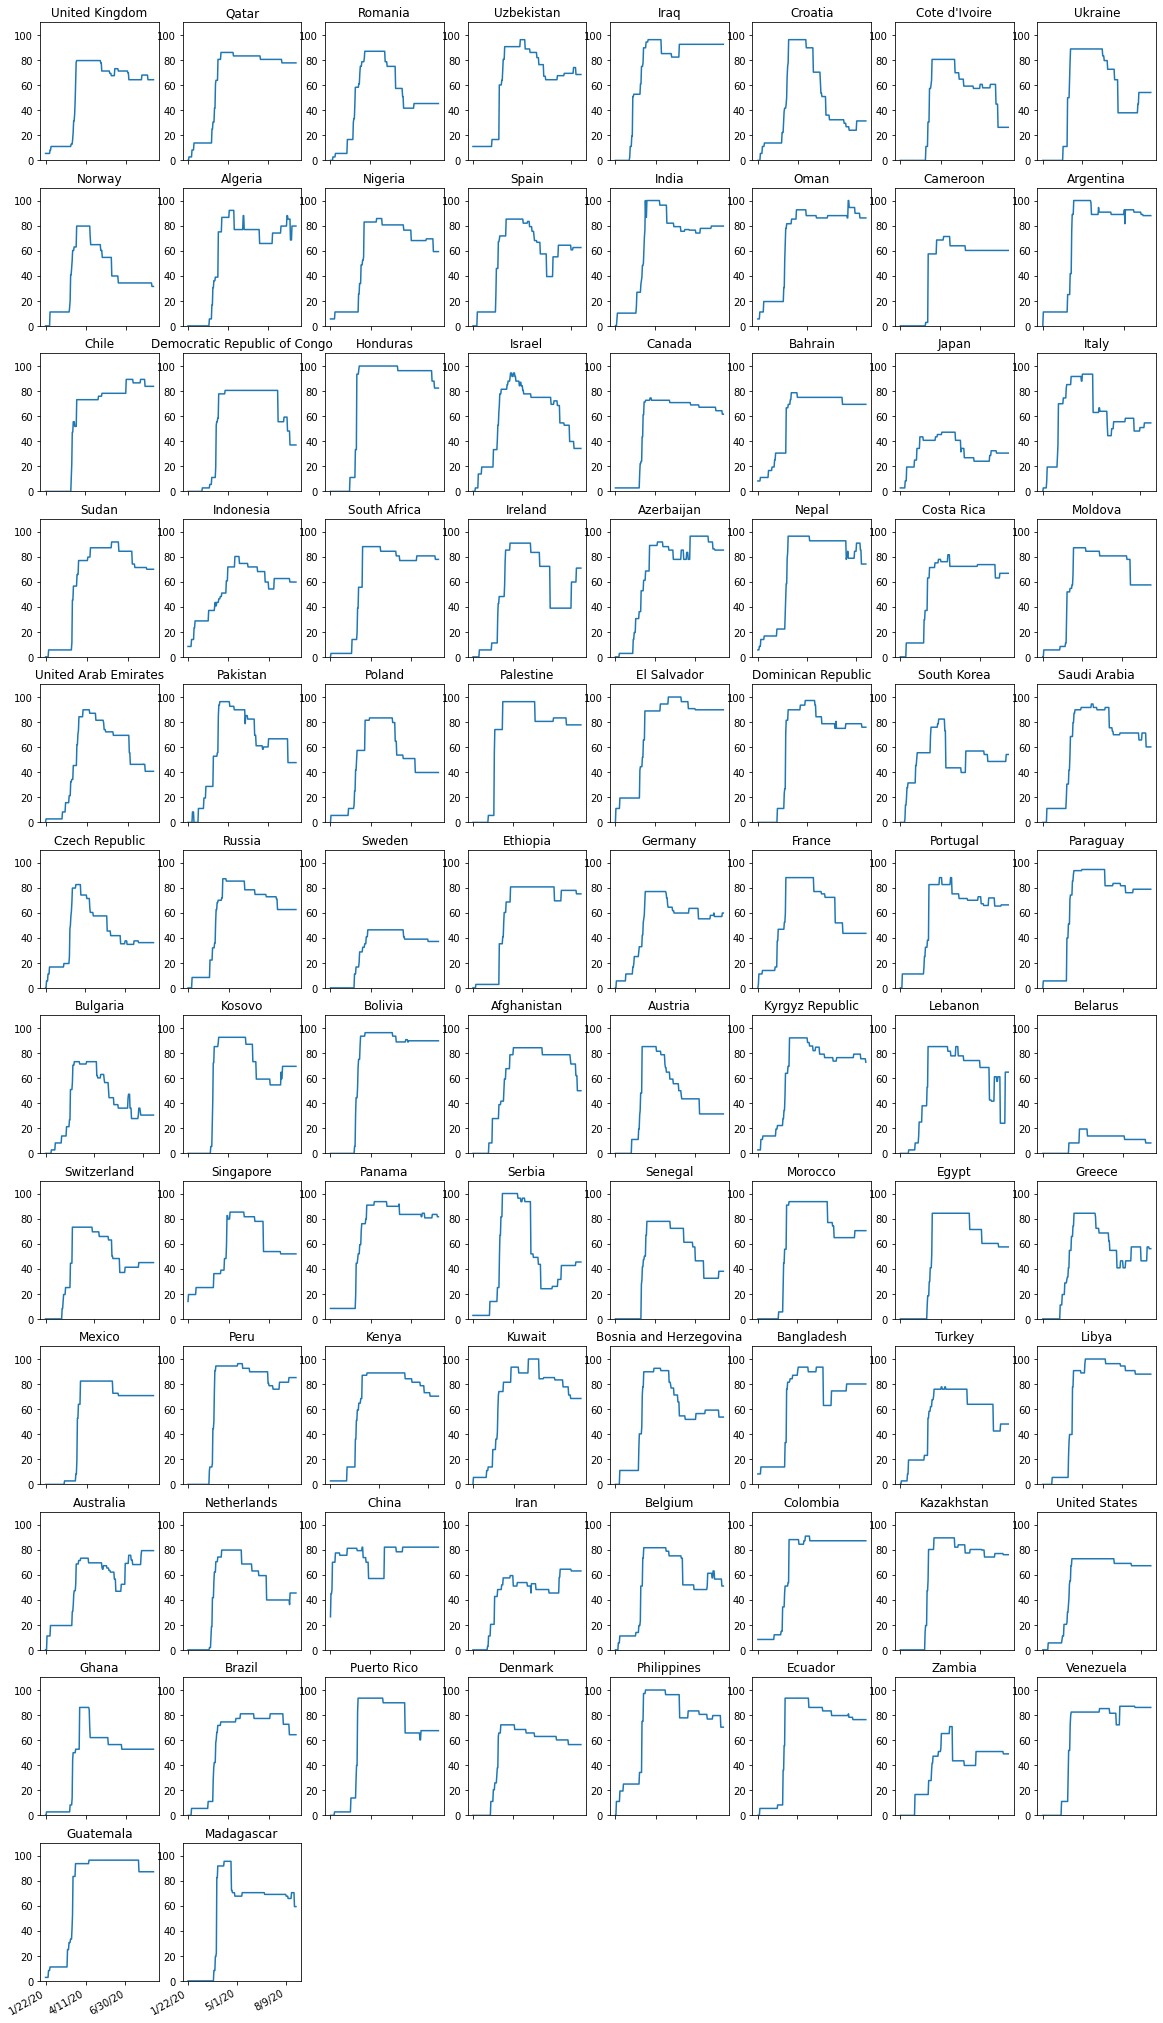

In [44]:
max_rows=12
max_cols=8
idx = 0
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,40))
fig.autofmt_xdate()
for idx, country  in enumerate(countriesox):
    foo = get_stringency(country)
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].set_ylim((0,110))
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(3))
    axes[row, col].fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    axes[row, col].plot(foo[0],foo[1])
    axes[row, col].set_title(country)
for idx in range(len(countriesox),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")

In [45]:
len(countriesox)

90

In [46]:
import pickle as pk

In [47]:
dicstringency={}
for cc in countriesox:
    foo = get_stringency(cc)
    dicstringency[cc] = [x[1] for x in foo] # skip date
dates = [x[0] for x in foo]
stringency={}
stringency['dates'] = dates
stringency['data'] = dicstringency
pk.dump(stringency,open('stringency.pk','wb'))

first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
f

## Plots of data for Cautionary Model comparison

Comment out line 1110 in pwlf.py (in /⁨usr⁩/local⁩/lib⁩/⁨python3.7⁩/site-packages⁩/pwlf⁩ directory)
    print("Warning: zero length interval encountered in pwlf.py calc_slopes").  
to remove repeated warnings, which don't seem to harm final result
    Warning: zero length interval encountered in pwlf.py calc_slopes

Parameter type | Parameter value  | Standard error   | t                | P > np.abs(t) (p-value)
Slope          |    -1495.953     |     5391.589     |       -0.277     |        0.782
Slope          |      236.966     |      369.860     |        0.641     |        0.522
Slope          |     3981.773     |      394.981     |       10.081     |        0.000
Slope          |    -3863.307     |      143.420     |      -26.937     |        0.000
Slope          |  -132387.297     |    17323.342     |       -7.642     |        0.000
Breakpoint     |       25.516     |        1.719     |       14.841     |        0.000
Breakpoint     |       75.753     |        1.237     |       61.254     |        0.000
Breakpoint     |      196.037     |        0.182     |     1079.586     |        0.000

Parameter type | Parameter value  | Standard error   | t                | P > np.abs(t) (p-value)
Slope          |   -56517.187     |     6216.412     |       -9.092     |        0.000
Slope          |    

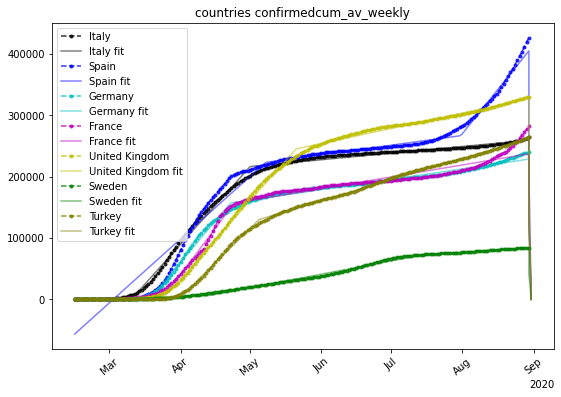

In [48]:
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
             'confirmed','cum_av_weekly',firstdate='02/15/20',lastdate='09/1/20',fittype='piecewise-linear',nsegments=4)
if savefigs:
    plt.savefig("covid-19-caution/figures/fig1a.pdf",bbox_inches='tight')

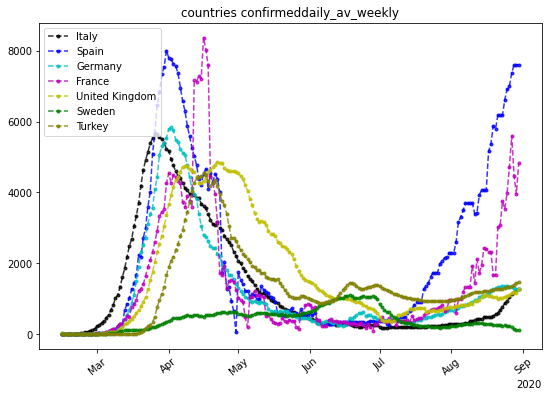

In [49]:
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
            'confirmed','daily_av_weekly',firstdate='02/15/20',lastdate='08/31/20',database='jhu')
if savefigs:
    plt.savefig("covid-19-caution/figures/fig1b.pdf",bbox_inches='tight')

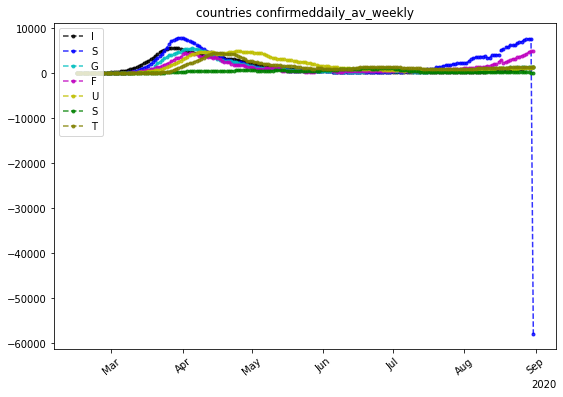

In [50]:
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
            'confirmed','daily_av_weekly',firstdate='02/15/20',lastdate='08/31/20',database='owid')
if savefigs:
    plt.savefig("covid-19-caution/figures/fig1b_owid.pdf",bbox_inches='tight')

# Parameter fitting

## Fitting via sliders

### SC3EIR Model

In [51]:
len(t)

NameError: name 't' is not defined

In [ ]:
model = 'SC3EIR'
params={'beta':0.25,'alpha':1./5.,'gamma':0.1,'mu':0.05,'c_0':0.3, 'c_1':1/14., 'c_2':2000}
def slidefitplot(beta,alpha,gamma,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta':beta, 'alpha':alpha, 'gamma':gamma, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.]
    cmodels[model].initial_values = (x0,t[0])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths'],tmax=len(t),summing='daily',fitdata=y_jhu[test_country],scale='linear',plottitle= '',label='confirmed',newplot = True)

In [52]:
interact(slidefitplot,
         beta=FloatSlider(min=0,max=1,step=0.01,value=params['beta'],description='beta',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         gamma=FloatSlider(min=0,max=1,step=0.01,value=params['gamma'],description='gamma',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False))

NameError: name 'slidefitplot' is not defined

### SC3EI3R Model

#### Germany

In [ ]:
# assumed data starting on firstdate
test_country='Germany'
N = 80000000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
len(t)

In [ ]:
(1.0/TimeICUDeath)*(CFR/FracCritical)

In [17]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days  : includes time for reg. of recovery
FracMild=0.7  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=5 #Time from ICU admission to death, days
DurHosp=4 #Duration of hospitalization, days  : includes 4 day reg of recovery

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=1.0  # Fraction of recovered individuals measured : plots made with this parameter NYI
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

NameError: name 'x0_SC3EI3R' is not defined

In [ ]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

In [ ]:
params=w.kwargs

print(params)

#### Spain

In [ ]:
# assumed data starting on firstdate
test_country='Spain'
N = 80000000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
len(t)

In [ ]:
(1.0/TimeICUDeath)*(CFR/FracCritical)

In [ ]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days  : includes time for reg. of recovery
FracMild=0.7  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=5 #Time from ICU admission to death, days
DurHosp=4 #Duration of hospitalization, days  : includes 4 day reg of recovery

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of confirmed individuals measured : plots made with this parameter NYI
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

In [ ]:
params=w.kwargs

print(params)

#### Italy

In [ ]:
# assumed data starting on firstdate
test_country='Italy'
N = 66650000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=4 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of infected individuals confirmed
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

In [ ]:
params=w.kwargs

print(params)

Note that we have used 50% detection of confirmed and recovered, 100% for deaths in manual fit. 
It appears that Italy's registration of recovery, although the right overall magnitude is markedly delayed - check reporting delays.
Italy also had at least two successive regional infections, as seen in the dual peak confirmed data, so not easy to fit with one model.
See below for simulation of second peak.

In [ ]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

#### Brazil

In [ ]:
# assumed data starting on firstdate
test_country='Brazil'
N = 210000000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=8 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='cumulative',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

The Brazil data shows that death is not as delayed as assumed. The process of progression is perhaps less clearly documented.

#### Russia

In [ ]:
# assumed data starting on firstdate
test_country='Iran'
N = 144500000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=8 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='cumulative',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

### SC3UEIR Model

In [ ]:
# assumed data starting on firstdate
test_country='US'
N = 66650000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
model = 'SC3UEIR'
I_0 =  0.00003
x0_SC3UEIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC3UEIR_model.initial_values = (x0_SC3UEIR, t[0])

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=8 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# Model extension by John McCaskill to include economic influence on caution 
EconomicCostOfCaution= 0.5 # Fractional reduction of economic contribution for cautioned individuals

p = [0,(1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,  (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere))]
g = [0,(1.0/DurMildInf)*FracMild,   (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
           (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical)]
u = (1.0/TimeICUDeath)*(CFR/FracCritical)
                
params = {'beta' : Exposure/sum(x0_SC3UEIR),
          'alpha' : 1.0/IncubPeriod,
          'gamma' :  g[1]+g[2]*(p[1]/(g[2]+p[2]))+g[3]*(p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u)),
          'mu'     : u*(p[1]/(g[2]+p[2])*(p[2]/(g[3]+u))),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3UEIR)*ICUFrac*CautionICUFrac),
          'N'      : sum(x0_SC3UEIR),
          'k_u'    : 1.0/CautionRetention,
          'k_1'    : 1.0/CautionRetention,
          'k_w'    : 1.0/CautionRetention,
          'kappa'  : EconomicCostOfCaution}

print(params)
SC3UEIR_model.parameters = params.copy()
# solution = SCIR_model.integrate(t[1::])

def slidefitplot(beta,alpha,gamma,mu,c_0,c_1,c_2,logI_0,k_u,k_1,k_w,kappa):
    params={ 'beta':beta, 'alpha':alpha, 'gamma':gamma, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2, 'k_u':k_u, 'k_1':k_1, 'k_w':k_w, 'kappa':kappa}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,1.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w = interactive(slidefitplot,
         beta=FloatSlider(min=0,max=1,step=0.01,value=params['beta'],description='beta',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         gamma=FloatSlider(min=0,max=1,step=0.01,value=params['gamma'],description='gamma',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))
display(w)

In [ ]:
params=w.kwargs
# not a good fit yet, did better last week
print(params)

### SC3UEI3R Model

#### USA

In [ ]:
# assumed data starting on firstdate
test_country='US'
N = 66650000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
model = 'SC3UEI3R'
I_0 =  0.00003
x0_SC3UEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC3UEI3R_model.initial_values = (x0_SC3UEI3R, t[0])

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=5 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# Model extension by John McCaskill to include economic influence on caution 
EconomicCostOfCaution= 0.5 # Fractional reduction of economic contribution for cautioned individuals

p = [0,(1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,  (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere))]
g = [0,(1.0/DurMildInf)*FracMild,   (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
           (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical)]
u = (1.0/TimeICUDeath)*(CFR/FracCritical)
                
params = {'beta_1' : Exposure/sum(x0_SC3UEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(ICUFrac*CautionICUFrac),
          'k_u'    : 1.0/5.,
          'k_1'    : 1.0/90,
          'k_w'    : 1.0/90,
          'kappa'  : EconomicCostOfCaution,
          'N'      : sum(x0_SC3UEI3R)}

print(params)
SC3UEI3R_model.parameters = params.copy()

In [ ]:
def slidefitplot(beta_1,alpha,mu,c_0,c_1,c_2,logI_0,k_u,k_1,k_w,kappa):
    params={ 'beta_1':beta_1, 'alpha':alpha, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2, 'k_u':k_u, 'k_1':k_1, 'k_w':k_w, 'kappa':kappa}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.,1.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w=interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))
display(w)

In [ ]:
params=w.kwargs

print(params)

#### Spain

In [ ]:
# assumed data starting on firstdate
test_country='Spain'
N = 66650000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
model = 'SC3UEI3R'
I_0 =  0.00003
x0_SC3UEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC3UEI3R_model.initial_values = (x0_SC3UEI3R, t[0])

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=5 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# Model extension by John McCaskill to include economic influence on caution 
EconomicCostOfCaution= 0.5 # Fractional reduction of economic contribution for cautioned individuals

p = [0,(1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,  (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere))]
g = [0,(1.0/DurMildInf)*FracMild,   (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
           (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical)]
u = (1.0/TimeICUDeath)*(CFR/FracCritical)
                
params = {'beta_1' : Exposure/sum(x0_SC3UEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(ICUFrac*CautionICUFrac),
          'k_u'    : 1.0/5.,
          'k_1'    : 1.0/90,
          'k_w'    : 1.0/90,
          'kappa'  : EconomicCostOfCaution,
          'N'      : sum(x0_SC3UEI3R)}

print(params)
SC3UEI3R_model.parameters = params.copy()

In [ ]:
def slidefitplot(beta_1,alpha,mu,c_0,c_1,c_2,logI_0,k_u,k_1,k_w,kappa):
    params={ 'beta_1':beta_1, 'alpha':alpha, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2, 'k_u':k_u, 'k_1':k_1, 'k_w':k_w, 'kappa':kappa}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.,1.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w=interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))
display(w)

In [ ]:
params=w.kwargs

print(params)

## Fit SC3EI3R parameters to jhu data based on square_loss

### Fit c_0 , c_1 and c_2 as well as initial value of I_1

In [ ]:
SC3EI3R_model.parameters

In [ ]:
SC3EI3R_model.parameters = {'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.16666666666666669, 'gamma_3': 0.1, 'p_1': 0.030000000000000013, 'p_2': 0.08333333333333333, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'N': 1.0}

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
I0 =10**-7
x0_SC3EI3R = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]
SC3EI3R_model.parameters={'beta_1': 0.41, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.0166, 'c_2': 10000.0}
cautionparams = list(params.values())[-4:-1]
theta = [0.3,0.0167,10000.] # cautionparams
boxBounds = [(0.3,0.5),(0.01,0.02),(6000.,12000.)]
# set up optimization function with cost and sensitivity (Jacobian)
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:],
                      state_weight=[1.,10.],state_name=['R','D'],
                      target_param=['c_0','c_1','c_2'],target_state=['I_1'])
# perform optimization
res = minimize(fun=objSC3EI3R.costIV,
                jac=objSC3EI3R.sensitivityIV,
                x0=theta+[I0],
                bounds=boxBounds+[(0.00000001,0.000001)],
                #method='BFGS',
                method='SLSQP',
                #options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
                #options={'disp':True})
                options={'disp':True,'maxiter':1000,'eps':0.0001,'ftol':0.000001})
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SC3EI3R)
params_fit = params.copy()
params_fit['c_0'] = res.x[0]
params_fit['c_1'] = res.x[1]
params_fit['c_2'] = res.x[2]

SC3EI3R_model.params = params_fit
print(SC3EI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0_SC3EI3R.copy()
x0_fit[2] = res.x[3]
t_fit = np.linspace(0, 150, 1000)
#t_fit = t
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SC3EI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
#plt.plot(t[1::],y_jhu[test_country][1::,0], 'o',color='lightgreen') # infected observations
plt.plot(t[1::],y_jhu[test_country][1::,1], 'bo') # recovered
plt.plot(t[1::],10*y_jhu[test_country][1::,2], 'ro') # died x10
plt.plot(t_fit[1::], sol_fit[::,SC3EI3R_model.recovered]) # R
plt.plot(t_fit[1::], 10*sol_fit[::,SC3EI3R_model.deaths])  # D x10
#plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

## Testing fitting

### Generate test data based on SCEI3R simulation

In [ ]:
# Add noise
y = solution[:,2:7].copy()
#print('len(y)',len(y),'t',len(t),t[0],t[1],'...',t[-1])
np.random.seed(seed=6)
noise = np.random.normal(0,1.e-2,[len(t),5])
# ynoise = y *(1+noise)
ynoise = y *(1.0 + noise)
ynoise[ynoise<0] = 0
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go', label='I_1') 
plt.plot(t,ynoise[:,1], 'go', label='I_2') 
plt.plot(t,ynoise[:,2], 'go', label='I_3') 
plt.plot(t,ynoise[:,3], 'bo', label='R') 
plt.plot(t,ynoise[:,4], 'ro', label='D') 
plt.plot(t,y[:,0], 'g', label='I_1') 
plt.plot(t,y[:,1], 'g', label='I_2') 
plt.plot(t,y[:,2], 'g', label='I_3') 
plt.plot(t,y[:,3], 'b', label='R') 
plt.plot(t,y[:,4], 'r', label='D') 
plt.legend()
plt.ylim(0,0.003)
plt.show()

In [ ]:
# model with generating parameters 
print(params)
params_fit = params.copy()
print(params_fit['c_0'],params_fit['c_1'])
SCEI3R_model.params = params_fit

x0_fit = x0_SCEI3R.copy()
print(x0_fit)
#t_fit = numpy.linspace(0, 150, 1000)

t_fit = t
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
# print(len(sol_fit[0]))
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go',label='I_1') # infected observations
plt.plot(t,ynoise[:,1], 'go',label='I_2') # infected observations
plt.plot(t,ynoise[:,2], 'go',label='I_3') # infected observations
plt.plot(t,ynoise[:,3], 'bo',label='R') # recoverd
plt.plot(t,ynoise[:,4], 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red', 'black'])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
plt.legend()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

In [ ]:
params # use list(...) to convert to list

### Fit parameters to randomized simulation data based on square_loss

#### Fit c_0 and c_1 only

In [ ]:
# Initial guess of parameters, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [value for value in cautionparams]
theta = [0.21,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.0,10.0],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'])
# perform optimization
res = minimize(fun=objSCEI3R.cost,
                jac=objSCEI3R.sensitivity,
                x0=theta,
                #bounds=boxBounds,
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.0001})# ,'ftol':0.01})  #not BFGS
print(res)

#### Fit c_0 and c_1 as well as initial value of E

##### Fit c_0 and c_1 as well as initial value of E with 'SLSQP'
does not work well
note use of special methods IV for initial value fitting of target_state

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='SLSQP',
                options={'disp':True,'maxiter':1000,'eps':0.01,'ftol':0.01})
print(res)

##### Fit c_0 and c_1 as well as initial value of E with BFGS
works well:  no constraints and gtol not ftol

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SCEI3R)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SCEI3R_model.params = params_fit
print(SCEI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go') # infected observations
plt.plot(t,ynoise[:,1], 'go') # infected observations
plt.plot(t,ynoise[:,2], 'go') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

##### Fit c_0 and c_1 as well as initial value of E using L-BFGS-B
this method does not work well

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                bounds=boxBounds+[(0.0000001,0.001)],
                method='L-BFGS-B',
                options={'disp':True,'maxiter':1000,'eps':0.0001,'ftol':0.001})
print(res)

In [ ]:
objSCEI3R.residual()

##### Fit c_0 and c_1 as well as initial value of E with Nelder-Mead
no use of Jacobian and no constraints

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                #jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='Nelder-Mead',
                options={'disp':True,'maxiter':1000}) #,'eps':0.0001,'ftol':0.01}) #not NM
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SCEI3R)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SCEI3R_model.params = params_fit
print(SCEI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0_SCEI3R.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go') # infected observations
plt.plot(t,ynoise[:,1], 'go') # infected observations
plt.plot(t,ynoise[:,2], 'go') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

## Fit SC2IR parameters to jhu data based on square_loss

In [ ]:
params=SC2IR_model.parameters
print(params)

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
theta = [0.4,0.11,0.007,0.33,0.228,275.]
boxBounds = [(0.2,0.5),(0.05,0.15),(0.005,0.015),(0.25,0.55),(0.15,0.4),(5.,2000.)]
# setup cost function and Jacobian with target parameters and initial states
objSC2IR = SquareLoss(theta=theta, ode=SC2IR_model, x0=x0, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:3],
                      state_weight=[0.2,1.],state_name=['R','D'],
                      target_param=['beta','gamma','mu','c_0','c_1','c_2'],
                      target_state=['I'])
# perform optimization
res = minimize(fun=objSC2IR.costIV,
                jac=objSC2IR.sensitivityIV,
                x0=theta+[0.000000001],
                bounds=boxBounds+[(0.0000000001,0.000001)],
                # method='L-BFGS-B',
                # method='Nelder-Mead',
                #options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
                options={'disp':True,'maxiter':1000,'eps':0.000001,'ftol':0.000000001})
print(res)

In [ ]:
# model with fitted parameters 
startparams = SC2IR_model.parameters.copy()  # save starting parameters (not fit)
print(params)
print(x0)
params_fit = params.copy()
params_fit['beta'] = res.x[0]
params_fit['gamma'] = res.x[1]
params_fit['mu'] = res.x[2]
params_fit['c_0'] = res.x[3]
params_fit['c_1'] = res.x[4]
params_fit['c_2'] = res.x[5]

SC2IR_model.params = params_fit
print(SC2IR_model.params)
x0_fit = x0.copy()
x0_fit[1] = res.x[6]
t_fit = t
SC2IR_model.initial_values = (x0_fit, t_fit[0])
sol_fit = scipy.integrate.odeint(SC2IR_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.semilogy()
plt.ylim([0.000001,1])
plt.plot(t,y_jhu[test_country][:,1], 'bo',label='R')  # recovered
plt.semilogy()
plt.ylim([0.000001,1])
plt.plot(t,y_jhu[test_country][:,2], 'ro',label='D')  # died
plt.semilogy()
plt.ylim([0.000001,1])

plt.gca().set_prop_cycle(color=['grey','green','blue','red', 'black'])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0.000001,1])
plt.legend(('R','D','S','I','R','D','S_c','I_c'))
plt.semilogy()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,1])
print('Peak infection (days)', t_fit[peak_i])
SC2IR_model.parameters = startparams

## Fit SC3EI3R parameters to jhu data based on square_loss

### Fit c_0 and c_1 only

In [ ]:
# Initial guess of parameters, and bounding constraints
cautionparams = list(params.values())[-4:-1]
theta = [value for value in cautionparams]
print(theta)
theta = [0.3,0.08,2500.]
boxBounds = [(0.2,0.8),(0.05,0.15),(100.,10000.)]
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:3],
                      state_weight=[1.,1.],state_name=['R','D'],
                      target_param=['c_0','c_1','c_2'])
# perform optimization
res = minimize(fun=objSC3EI3R.cost,
                #jac=objSC3EI3R.sensitivity,
                x0=theta,
                #bounds=boxBounds,
                method='L-BFGS-B',
                # method='Nelder-Mead',
                options={'disp':True,'maxiter':1000,'eps':0.00001})# ,'ftol':0.01})  #not BFGS
print(res)

### Fit c_0 and c_1 as well as initial value of E

#### Fit c_0 and c_1 as well as initial value of E with 'SLSQP'
does not work well
note use of special methods IV for initial value fitting of target_state

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-3]
theta = [value for value in cautionparams]
theta = [0.21,0.08,2500.]
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:3],
                      state_weight=[1.,1.],state_name=['R','D'],
                      target_param=['c_0','c_1','c_2'],target_state=['I_1'])
# perform optimization
res = minimize(fun=objSC3EI3R.costIV,
                jac=objSC3EI3R.sensitivityIV,
                x0=theta+[0.00005],
                bounds=boxBounds+[(0.0000001,0.001)],
                # method='BFGS',
                method='L-BFGS-B',
                options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
print(res)

#### Fit c_0 and c_1 as well as initial value of E with BFGS
works well:  no constraints and gtol not ftol

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SC3EI3R)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SC3EI3R_model.params = params_fit
print(SC3EI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0_SC3EI3R.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SC3EI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'o',color='lightgreen') # infected observations
plt.plot(t,ynoise[:,1], 'o',color='green') # infected observations
plt.plot(t,ynoise[:,2], 'o',color='darkgreen') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

#### Fit c_0 and c_1 as well as initial value of E using L-BFGS-B
this method does not work well

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                bounds=boxBounds+[(0.0000001,0.001)],
                method='L-BFGS-B',
                options={'disp':True,'maxiter':1000,'eps':0.0001,'ftol':0.001})
print(res)

In [ ]:
objSCEI3R.residual()

#### Fit c_0 and c_1 as well as initial value of E with Nelder-Mead
no use of Jacobian and no constraints

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                #jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='Nelder-Mead',
                options={'disp':True,'maxiter':1000}) #,'eps':0.0001,'ftol':0.01}) #not NM
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SC3EI3R)
params_fit = params.copy()
params_fit['c_0'] = res.x[0]
params_fit['c_1'] = res.x[1]

SC3EI3R_model.params = params_fit
print(SC3EI3R_model.params)
x0_fit = x0_SC3EI3R.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SC3EI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SC3EI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SC3EI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,y_jhu[:,0], 'bo') # recoverd
plt.plot(t,y_jhu[:,1], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

### Information on method options

In [ ]:
scipy.optimize.show_options(solver='minimize', method='SLSQP', disp=True)
print(' ')
scipy.optimize.show_options(solver='minimize', method='L-BFGS-B', disp=True)

## Plot using full control

In [ ]:
def plotmodel(solns,t,scale='linear',species='no_susc',plottitle= '',label='',
              newplot = True,models=['SEI3R','SCEI3R','SC3EI3R']):
    """
    plot solns over 
    times t interpreted as models indicated in models parameter
    scale: alternative 'linear' or 'log'
    species alternatives 'all', 'confirmed', 'deaths', 'daily confirmed', 'daily deaths'
    plottitle : title for plot
    label : label for curve when called as part of multicurve plot
    newplot : whether to open new plot True/False
    models : list of models to include, default all three of those possible
    """
   
    nmodels = len(models)
    if len(solns) != len(models):
        print("Error: number of models must match number of solutions")
        return None
    nm = 0
    
    if newplot == True:
        plt.figure(figsize=(nmodels*8,6))
 
    for nm in range(nmodels):
        soln = solns[nm]
        if models[nm] == 'SEI3R':   #SEI3R
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(tvec,soln[:,1:5],label=label)
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1)
                # print('length=',len(suma))
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    #plt.ylim([0,1000])
                    plt.plot(tvec,sumd,label=label)
                else:
                    #plt.ylim([0,200000])
                     plt.plot(t,suma,label=label)                   
            elif species == 'all':
                plt.plot(tvec,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SEI3R %s' % plottitle)

        elif models[nm] == 'SCEI3R':   #SCEI3R
            #Plot
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(t,soln[:,1:5],label=label)
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1)
                # print('length=',len(suma))
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    #plt.ylim([0,1000])
                    plt.plot(t,sumd,label=label)
                else:
                    #plt.ylim([0,200000])
                    plt.plot(t,suma,label=label)
            elif species == 'all':
                plt.plot(t,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SCEI3R %s' % plottitle)
        elif models[nm] == 'SC3EI3R':   #SC3EI3R
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(t,sol[:,1:5])
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1) + soln[:,9]
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    # plt.ylim([0,1000])
                    plt.plot(t,sumd,label=label)
                else:
                    # plt.ylim([0,200000])
                    plt.plot(t,suma,label=label)
            elif species == 'all':
                plt.plot(t,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D","Sc","Ec","I1c"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SC3EI3R %s' % plottitle)
    return True

In [ ]:
plotmodel([sol_fit],t_fit[1:],scale='linear',species='no_susc',plottitle= 'test',label='',
              newplot = True,models=['SCEI3R'])